In [14]:
import os
import time
from typing import List, Tuple
import pandas as pd
import numpy as np
import torch
from transformers import T5ForConditionalGeneration, AutoTokenizer
from tqdm import tqdm
from score import sari_score
import matplotlib.pyplot as plt


# Extension 2: Adaptive Decoding Strategy for Real-Time Simplification

This extension implements an **adaptive decoding strategy** that optimizes for both quality and latency in real-time text simplification scenarios. The key innovation is using different decoding strategies based on the completion ratio:

- **Early stages (25%, 50%)**: Use greedy decoding (num_beams=1) for fast, low-latency generation
- **Later stages (75%, 100%)**: Use beam search (num_beams=4) for higher quality when more context is available

Additionally, we implement:
- **Context-aware length penalty**: Dynamically adjusts based on source length and completion ratio (not just completion ratio like Extension 1)


In [15]:
def get_sentence_prefix(source: str, completion_ratio: float) -> str:
    """Extract a prefix of the source sentence based on completion ratio."""
    tokens = source.split()
    num_tokens = len(tokens)
    prefix_length = max(1, int(num_tokens * completion_ratio))
    prefix_tokens = tokens[:prefix_length]
    return ' '.join(prefix_tokens)


In [16]:
def compute_context_aware_length_penalty(source: str, completion_ratio: float) -> float:
    """
    Compute length penalty based on source length and completion ratio.
    
    Strategy:
    - Shorter sources need less aggressive length penalty
    - Early completion ratios benefit from lower length penalty (shorter outputs)
    - Later completion ratios can use higher length penalty (more complete outputs)
    """
    source_length = len(source.split())
    
    # Base length penalty increases with completion ratio
    base_penalty = 0.4 + (completion_ratio * 0.4)  # Range: 0.4 to 0.8
    
    # Adjust based on source length
    if source_length < 10:
        length_factor = 0.9  # Shorter sources: slightly lower penalty
    elif source_length < 20:
        length_factor = 1.0  # Medium sources: no adjustment
    else:
        length_factor = 1.1  # Longer sources: slightly higher penalty
    
    final_penalty = base_penalty * length_factor
    
    # Clamp to reasonable range
    return max(0.3, min(1.0, final_penalty))


In [17]:
def adaptive_incremental_simplify(
    model,
    tokenizer,
    source: str,
    completion_ratio: float,
    max_length: int = 128,
    device: str = 'cuda',
    measure_latency: bool = False
) -> Tuple[str, float]:
    """
    Adaptive incremental simplification with strategy selection based on completion ratio.
    
    Strategy:
    - Early completion (25%, 50%): Greedy decoding for low latency
    - Late completion (75%, 100%): Beam search for higher quality
    
    Returns:
        Tuple of (simplified_text, latency_in_seconds)
    """
    prefix = get_sentence_prefix(source, completion_ratio)
    
    # Adaptive decoding strategy
    if completion_ratio <= 0.5:
        # Early stage: use greedy decoding (num_beams=1) for maximum speed
        # This is much faster than beam search while still producing reasonable quality
        num_beams = 1
        do_sample = False  # True greedy decoding for maximum speed
    else:
        # Late stage: use beam search for quality when more context is available
        num_beams = 4
        do_sample = False
    
    # Context-aware length penalty
    length_penalty = compute_context_aware_length_penalty(source, completion_ratio)
    
    model.eval()
    start_time = time.time()
    
    with torch.no_grad():
        input_text = "simplify: " + prefix
        input_enc = tokenizer(
            input_text,
            max_length=max_length,
            truncation=True,
            return_tensors='pt'
        ).to(device)
        
        generation_kwargs = {
            'input_ids': input_enc['input_ids'],
            'attention_mask': input_enc['attention_mask'],
            'max_length': max_length,
            'length_penalty': length_penalty,
            'early_stopping': True,
            'no_repeat_ngram_size': 2,
            'num_beams': num_beams,
            'do_sample': do_sample,
        }
        
        output_ids = model.generate(**generation_kwargs)
        output_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    
    latency = time.time() - start_time if measure_latency else 0.0
    
    return output_text, latency


In [18]:
# Load model and data
model_dir = './t5-simplification'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
max_length = 128

print("Loading fine-tuned T5 model...")
if not os.path.exists(model_dir):
    raise FileNotFoundError(
        f"Model directory {model_dir} not found. "
        "Please run strong_baseline.py first to train the model."
    )

tokenizer = AutoTokenizer.from_pretrained(model_dir, local_files_only=True)
model = T5ForConditionalGeneration.from_pretrained(model_dir, local_files_only=True)
model.to(device)
model.eval()
print("Model loaded successfully!")

print("Loading WikiLarge test dataset...")
test = pd.read_csv(
    "hf://datasets/bogdancazan/wikilarge-text-simplification/wiki.full.aner.ori.test.95.tsv",
    sep="\t"
)
print(f"Loaded {len(test)} test examples")


Loading fine-tuned T5 model...
Model loaded successfully!
Loading WikiLarge test dataset...
Loaded 191 test examples


In [19]:
# Evaluate Extension 2: Adaptive Decoding Strategy
completion_ratios = [0.25, 0.5, 0.75, 1.0]

print("\nEvaluating Extension 2: Adaptive Decoding Strategy...")
extension2_results = {ratio: {
    'sari': [], 
    'keep': [], 
    'delete': [], 
    'add': [],
    'latency': []
} for ratio in completion_ratios}

for idx, row in tqdm(test.iterrows(), total=len(test), desc="Processing"):
    source = row['Normal']
    reference = row['Simple']
    
    for ratio in completion_ratios:
        output, latency = adaptive_incremental_simplify(
            model, tokenizer, source, ratio,
            max_length=max_length,
            device=device,
            measure_latency=True
        )
        
        sari, components = sari_score(source, output, [reference])
        extension2_results[ratio]['sari'].append(sari)
        extension2_results[ratio]['keep'].append(components['keep'])
        extension2_results[ratio]['delete'].append(components['delete'])
        extension2_results[ratio]['add'].append(components['add'])
        extension2_results[ratio]['latency'].append(latency)



Evaluating Extension 2: Adaptive Decoding Strategy...


Processing: 100%|██████████| 191/191 [02:44<00:00,  1.16it/s]


In [20]:
# For comparison, also evaluate the fixed length penalty baseline (Baseline)
def incremental_simplify_baseline(
    model,
    tokenizer,
    source: str,
    completion_ratio: float,
    max_length: int = 128,
    num_beams: int = 4,
    length_penalty: float = 0.6,
    device: str = 'cuda',
    measure_latency: bool = False
) -> Tuple[str, float]:
    """Baseline incremental simplification with fixed parameters."""
    prefix = get_sentence_prefix(source, completion_ratio)
    
    model.eval()
    start_time = time.time()
    
    with torch.no_grad():
        input_text = "simplify: " + prefix
        input_enc = tokenizer(
            input_text,
            max_length=max_length,
            truncation=True,
            return_tensors='pt'
        ).to(device)
        
        output_ids = model.generate(
            input_ids=input_enc['input_ids'],
            attention_mask=input_enc['attention_mask'],
            max_length=max_length,
            num_beams=num_beams,
            length_penalty=length_penalty,
            early_stopping=True,
            no_repeat_ngram_size=2
        )
        
        output_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    
    latency = time.time() - start_time if measure_latency else 0.0
    return output_text, latency

# Extension 1: Adaptive length penalty (beam search with adaptive length penalty)
def extension1_adaptive_incremental_simplify(
    model,
    tokenizer,
    source: str,
    completion_ratio: float,
    max_length: int = 128,
    num_beams: int = 4,
    device: str = 'cuda',
    measure_latency: bool = False
) -> Tuple[str, float]:
    """Extension 1: Adaptive length penalty based on completion ratio."""
    if completion_ratio <= 0.25:
        length_penalty = 0.4
    elif completion_ratio <= 0.5:
        length_penalty = 0.5
    elif completion_ratio <= 0.75:
        length_penalty = 0.6
    else:
        length_penalty = 0.7
    
    return incremental_simplify_baseline(
        model, tokenizer, source, completion_ratio,
        max_length=max_length,
        num_beams=num_beams,
        length_penalty=length_penalty,
        device=device,
        measure_latency=measure_latency
    )

print("\nEvaluating Baseline (fixed length penalty) for comparison...")
baseline_results = {ratio: {
    'sari': [], 
    'keep': [], 
    'delete': [], 
    'add': [],
    'latency': []
} for ratio in completion_ratios}

for idx, row in tqdm(test.iterrows(), total=len(test), desc="Processing baseline"):
    source = row['Normal']
    reference = row['Simple']
    
    for ratio in completion_ratios:
        output, latency = incremental_simplify_baseline(
            model, tokenizer, source, ratio,
            max_length=max_length,
            num_beams=4,
            length_penalty=0.6,
            device=device,
            measure_latency=True
        )
        
        sari, components = sari_score(source, output, [reference])
        baseline_results[ratio]['sari'].append(sari)
        baseline_results[ratio]['keep'].append(components['keep'])
        baseline_results[ratio]['delete'].append(components['delete'])
        baseline_results[ratio]['add'].append(components['add'])
        baseline_results[ratio]['latency'].append(latency)

print("\nEvaluating Extension 1 (adaptive length penalty) for comparison...")
extension1_results = {ratio: {
    'sari': [], 
    'keep': [], 
    'delete': [], 
    'add': [],
    'latency': []
} for ratio in completion_ratios}

for idx, row in tqdm(test.iterrows(), total=len(test), desc="Processing extension1"):
    source = row['Normal']
    reference = row['Simple']
    
    for ratio in completion_ratios:
        output, latency = extension1_adaptive_incremental_simplify(
            model, tokenizer, source, ratio,
            max_length=max_length,
            num_beams=4,
            device=device,
            measure_latency=True
        )
        
        sari, components = sari_score(source, output, [reference])
        extension1_results[ratio]['sari'].append(sari)
        extension1_results[ratio]['keep'].append(components['keep'])
        extension1_results[ratio]['delete'].append(components['delete'])
        extension1_results[ratio]['add'].append(components['add'])
        extension1_results[ratio]['latency'].append(latency)



Evaluating Baseline (fixed length penalty) for comparison...


Processing baseline: 100%|██████████| 191/191 [03:28<00:00,  1.09s/it]



Evaluating Extension 1 (adaptive length penalty) for comparison...


Processing extension1: 100%|██████████| 191/191 [03:22<00:00,  1.06s/it]


In [21]:
# Print comprehensive comparison of all three approaches
print("\n" + "=" * 80)
print("COMPREHENSIVE COMPARISON: Baseline vs Extension 1 vs Extension 2")
print("=" * 80)

print("\n" + "=" * 80)
print("SARI Scores Comparison")
print("=" * 80)
print(f"\n{'Completion Ratio':<20} {'Baseline':<15} {'Extension 1':<18} {'Extension 2':<18}")
print("-" * 80)

for ratio in completion_ratios:
    baseline_sari = np.mean(baseline_results[ratio]['sari'])
    ext1_sari = np.mean(extension1_results[ratio]['sari'])
    ext2_sari = np.mean(extension2_results[ratio]['sari'])
    
    print(f"{ratio*100:>5.0f}%{'':<14} {baseline_sari:>8.2f}      {ext1_sari:>11.2f}      {ext2_sari:>11.2f}")

print("=" * 80)

print("\n" + "=" * 80)
print("Latency Comparison (ms)")
print("=" * 80)
print(f"\n{'Completion Ratio':<20} {'Baseline':<15} {'Extension 1':<18} {'Extension 2':<18}")
print("-" * 80)

for ratio in completion_ratios:
    baseline_lat = np.mean(baseline_results[ratio]['latency']) * 1000
    ext1_lat = np.mean(extension1_results[ratio]['latency']) * 1000
    ext2_lat = np.mean(extension2_results[ratio]['latency']) * 1000
    
    print(f"{ratio*100:>5.0f}%{'':<14} {baseline_lat:>8.2f}      {ext1_lat:>11.2f}      {ext2_lat:>11.2f}")

print("=" * 80)

# Detailed tables for each approach
print("\n" + "=" * 80)
print("Baseline (Fixed Length Penalty) - Detailed Results")
print("=" * 80)
print(f"\n{'Completion Ratio':<20} {'SARI':<10} {'Keep':<10} {'Delete':<10} {'Add':<10} {'Avg Latency (ms)':<15}")
print("-" * 80)

for ratio in completion_ratios:
    sari_avg = np.mean(baseline_results[ratio]['sari'])
    keep_avg = np.mean(baseline_results[ratio]['keep'])
    del_avg = np.mean(baseline_results[ratio]['delete'])
    add_avg = np.mean(baseline_results[ratio]['add'])
    latency_avg = np.mean(baseline_results[ratio]['latency']) * 1000
    
    print(f"{ratio*100:>5.0f}%{'':<14} {sari_avg:>6.2f}    {keep_avg:>6.2f}    {del_avg:>6.2f}    {add_avg:>6.2f}    {latency_avg:>10.2f}")

print("=" * 80)

print("\n" + "=" * 80)
print("Extension 1 (Adaptive Length Penalty) - Detailed Results")
print("=" * 80)
print(f"\n{'Completion Ratio':<20} {'SARI':<10} {'Keep':<10} {'Delete':<10} {'Add':<10} {'Avg Latency (ms)':<15}")
print("-" * 80)

for ratio in completion_ratios:
    sari_avg = np.mean(extension1_results[ratio]['sari'])
    keep_avg = np.mean(extension1_results[ratio]['keep'])
    del_avg = np.mean(extension1_results[ratio]['delete'])
    add_avg = np.mean(extension1_results[ratio]['add'])
    latency_avg = np.mean(extension1_results[ratio]['latency']) * 1000
    
    print(f"{ratio*100:>5.0f}%{'':<14} {sari_avg:>6.2f}    {keep_avg:>6.2f}    {del_avg:>6.2f}    {add_avg:>6.2f}    {latency_avg:>10.2f}")

print("=" * 80)

print("\n" + "=" * 80)
print("Extension 2 (Adaptive Decoding Strategy) - Detailed Results")
print("=" * 80)
print(f"\n{'Completion Ratio':<20} {'SARI':<10} {'Keep':<10} {'Delete':<10} {'Add':<10} {'Avg Latency (ms)':<15}")
print("-" * 80)

for ratio in completion_ratios:
    sari_avg = np.mean(extension2_results[ratio]['sari'])
    keep_avg = np.mean(extension2_results[ratio]['keep'])
    del_avg = np.mean(extension2_results[ratio]['delete'])
    add_avg = np.mean(extension2_results[ratio]['add'])
    latency_avg = np.mean(extension2_results[ratio]['latency']) * 1000
    
    print(f"{ratio*100:>5.0f}%{'':<14} {sari_avg:>6.2f}    {keep_avg:>6.2f}    {del_avg:>6.2f}    {add_avg:>6.2f}    {latency_avg:>10.2f}")

print("=" * 80)



COMPREHENSIVE COMPARISON: Baseline vs Extension 1 vs Extension 2

SARI Scores Comparison

Completion Ratio     Baseline        Extension 1        Extension 2       
--------------------------------------------------------------------------------
   25%                  28.74            28.74            28.75
   50%                  32.25            32.27            32.55
   75%                  33.92            33.92            33.84
  100%                  36.01            35.94            36.14

Latency Comparison (ms)

Completion Ratio     Baseline        Extension 1        Extension 2       
--------------------------------------------------------------------------------
   25%                 157.42           152.09            51.79
   50%                 228.67           221.19            78.74
   75%                 308.81           299.86           319.29
  100%                 395.77           382.12           408.33

Baseline (Fixed Length Penalty) - Detailed Results

Comple

In [22]:
# Improvement analysis
print("\n" + "=" * 80)
print("Improvement Analysis: Extension 1 and Extension 2 vs Baseline")
print("=" * 80)
print(f"\n{'Completion Ratio':<20} {'Ext1 vs Base':<18} {'Ext2 vs Base':<18} {'Ext2 vs Ext1':<18}")
print("-" * 80)

for ratio in completion_ratios:
    baseline_sari = np.mean(baseline_results[ratio]['sari'])
    ext1_sari = np.mean(extension1_results[ratio]['sari'])
    ext2_sari = np.mean(extension2_results[ratio]['sari'])
    
    ext1_improvement = ext1_sari - baseline_sari
    ext2_improvement = ext2_sari - baseline_sari
    ext2_vs_ext1 = ext2_sari - ext1_sari
    
    print(f"{ratio*100:>5.0f}%{'':<14} {ext1_improvement:>+8.2f}      {ext2_improvement:>+8.2f}      {ext2_vs_ext1:>+8.2f}")

print("=" * 80)

# Calculate overall improvements
baseline_avg = np.mean([np.mean(baseline_results[r]['sari']) for r in completion_ratios])
ext1_avg = np.mean([np.mean(extension1_results[r]['sari']) for r in completion_ratios])
ext2_avg = np.mean([np.mean(extension2_results[r]['sari']) for r in completion_ratios])

print(f"\nOverall Average SARI:")
print(f"  Baseline:     {baseline_avg:.2f}")
print(f"  Extension 1: {ext1_avg:.2f} ({ext1_avg-baseline_avg:+.2f}, {(ext1_avg-baseline_avg)/baseline_avg*100:+.2f}%)")
print(f"  Extension 2: {ext2_avg:.2f} ({ext2_avg-baseline_avg:+.2f}, {(ext2_avg-baseline_avg)/baseline_avg*100:+.2f}%)")
print(f"  Ext2 vs Ext1: {ext2_avg-ext1_avg:+.2f} ({(ext2_avg-ext1_avg)/ext1_avg*100:+.2f}%)")

# Latency improvements
baseline_lat_avg = np.mean([np.mean(baseline_results[r]['latency']) for r in completion_ratios]) * 1000
ext1_lat_avg = np.mean([np.mean(extension1_results[r]['latency']) for r in completion_ratios]) * 1000
ext2_lat_avg = np.mean([np.mean(extension2_results[r]['latency']) for r in completion_ratios]) * 1000

print(f"\nOverall Average Latency (ms):")
print(f"  Baseline:     {baseline_lat_avg:.2f}")
print(f"  Extension 1: {ext1_lat_avg:.2f} ({ext1_lat_avg-baseline_lat_avg:+.2f} ms)")
print(f"  Extension 2: {ext2_lat_avg:.2f} ({ext2_lat_avg-baseline_lat_avg:+.2f} ms, {(baseline_lat_avg/ext2_lat_avg):.2f}x speedup)")



Improvement Analysis: Extension 1 and Extension 2 vs Baseline

Completion Ratio     Ext1 vs Base       Ext2 vs Base       Ext2 vs Ext1      
--------------------------------------------------------------------------------
   25%                  +0.00         +0.01         +0.01
   50%                  +0.02         +0.31         +0.28
   75%                  +0.00         -0.08         -0.08
  100%                  -0.07         +0.13         +0.20

Overall Average SARI:
  Baseline:     32.73
  Extension 1: 32.72 (-0.01, -0.03%)
  Extension 2: 32.82 (+0.09, +0.28%)
  Ext2 vs Ext1: +0.10 (+0.31%)

Overall Average Latency (ms):
  Baseline:     272.66
  Extension 1: 263.81 (-8.85 ms)
  Extension 2: 214.54 (-58.13 ms, 1.27x speedup)


In [23]:
# Detailed latency analysis for all approaches
print("\n" + "=" * 80)
print("Detailed Latency Analysis")
print("=" * 80)

print("\nBaseline Latency:")
print(f"{'Completion Ratio':<20} {'Avg (ms)':<15} {'Std Dev (ms)':<15} {'Min (ms)':<15} {'Max (ms)':<15}")
print("-" * 80)
for ratio in completion_ratios:
    latencies = baseline_results[ratio]['latency']
    avg_latency = np.mean(latencies) * 1000
    std_latency = np.std(latencies) * 1000
    min_latency = np.min(latencies) * 1000
    max_latency = np.max(latencies) * 1000
    print(f"{ratio*100:>5.0f}%{'':<14} {avg_latency:>8.2f}      {std_latency:>8.2f}      {min_latency:>8.2f}      {max_latency:>8.2f}")

print("\nExtension 1 Latency:")
print(f"{'Completion Ratio':<20} {'Avg (ms)':<15} {'Std Dev (ms)':<15} {'Min (ms)':<15} {'Max (ms)':<15}")
print("-" * 80)
for ratio in completion_ratios:
    latencies = extension1_results[ratio]['latency']
    avg_latency = np.mean(latencies) * 1000
    std_latency = np.std(latencies) * 1000
    min_latency = np.min(latencies) * 1000
    max_latency = np.max(latencies) * 1000
    print(f"{ratio*100:>5.0f}%{'':<14} {avg_latency:>8.2f}      {std_latency:>8.2f}      {min_latency:>8.2f}      {max_latency:>8.2f}")

print("\nExtension 2 Latency:")
print(f"{'Completion Ratio':<20} {'Avg (ms)':<15} {'Std Dev (ms)':<15} {'Min (ms)':<15} {'Max (ms)':<15}")
print("-" * 80)
for ratio in completion_ratios:
    latencies = extension2_results[ratio]['latency']
    avg_latency = np.mean(latencies) * 1000
    std_latency = np.std(latencies) * 1000
    min_latency = np.min(latencies) * 1000
    max_latency = np.max(latencies) * 1000
    print(f"{ratio*100:>5.0f}%{'':<14} {avg_latency:>8.2f}      {std_latency:>8.2f}      {min_latency:>8.2f}      {max_latency:>8.2f}")

print("=" * 80)

# Speedup analysis
print("\nSpeedup Analysis:")
print("  Baseline & Extension 1: Always use beam search (num_beams=4)")
print("  Extension 2: Greedy (num_beams=1) for 25%, 50%; Beam search (num_beams=4) for 75%, 100%")

baseline_early = np.mean(baseline_results[0.25]['latency'] + baseline_results[0.5]['latency']) * 1000
baseline_late = np.mean(baseline_results[0.75]['latency'] + baseline_results[1.0]['latency']) * 1000
ext2_early = np.mean(extension2_results[0.25]['latency'] + extension2_results[0.5]['latency']) * 1000
ext2_late = np.mean(extension2_results[0.75]['latency'] + extension2_results[1.0]['latency']) * 1000

print(f"\n  Baseline average latency:")
print(f"    Early stages (25% + 50%): {baseline_early:.2f} ms")
print(f"    Late stages (75% + 100%): {baseline_late:.2f} ms")
print(f"\n  Extension 2 average latency:")
print(f"    Early stages (25% + 50%): {ext2_early:.2f} ms")
print(f"    Late stages (75% + 100%): {ext2_late:.2f} ms")
print(f"\n  Extension 2 speedup over Baseline:")
print(f"    Early stages: {baseline_early/ext2_early:.2f}x faster")
print(f"    Late stages: {baseline_late/ext2_late:.2f}x (similar, both use beam search)")



Detailed Latency Analysis

Baseline Latency:
Completion Ratio     Avg (ms)        Std Dev (ms)    Min (ms)        Max (ms)       
--------------------------------------------------------------------------------
   25%                 157.42         87.79         44.93        586.67
   50%                 228.67        113.61         75.57        690.54
   75%                 308.81        139.60         95.78        840.77
  100%                 395.77        168.17        149.65       1079.41

Extension 1 Latency:
Completion Ratio     Avg (ms)        Std Dev (ms)    Min (ms)        Max (ms)       
--------------------------------------------------------------------------------
   25%                 152.09         87.15         43.19        627.58
   50%                 221.19        110.91         81.16        665.86
   75%                 299.86        135.48         93.13        774.99
  100%                 382.12        160.84        148.16       1032.39

Extension 2 Latency:
Co

In [24]:
# Example outputs
print("\n" + "=" * 70)
print("Example: Adaptive Decoding Strategy")
print("=" * 70)

example_idx = 0
source = test.iloc[example_idx]['Normal']
reference = test.iloc[example_idx]['Simple']

print(f"\nSource: {source}")
print(f"Reference: {reference}")
print("\n" + "-" * 70)

for ratio in completion_ratios:
    prefix = get_sentence_prefix(source, ratio)
    output, latency = adaptive_incremental_simplify(
        model, tokenizer, source, ratio,
        max_length=max_length,
        device=device,
        measure_latency=True
    )
    sari, _ = sari_score(source, output, [reference])
    
    strategy = "Greedy" if ratio <= 0.5 else "Beam Search"
    num_beams = 1 if ratio <= 0.5 else 4
    
    print(f"\n[{ratio*100:.0f}% context] - {strategy} (beams={num_beams})")
    print(f"  Prefix: {prefix}")
    print(f"  Output: {output}")
    print(f"  SARI: {sari:.2f}, Latency: {latency*1000:.2f} ms")



Example: Adaptive Decoding Strategy

Source: his next work saturday follows an especially eventful day in the life of a successful neurosurgeon.
Reference: his next work at saturday will be a successful neurosurgeon.

----------------------------------------------------------------------

[25% context] - Greedy (beams=1)
  Prefix: his next work saturday
  Output: his next work saturday
  SARI: 45.02, Latency: 57.08 ms

[50% context] - Greedy (beams=1)
  Prefix: his next work saturday follows an especially eventful
  Output: his next work saturday follows an especially eventful
  SARI: 31.91, Latency: 74.95 ms

[75% context] - Beam Search (beams=4)
  Prefix: his next work saturday follows an especially eventful day in the life
  Output: his next work saturday follows an especially eventful day in the life
  SARI: 17.67, Latency: 232.47 ms

[100% context] - Beam Search (beams=4)
  Prefix: his next work saturday follows an especially eventful day in the life of a successful neurosurgeon.

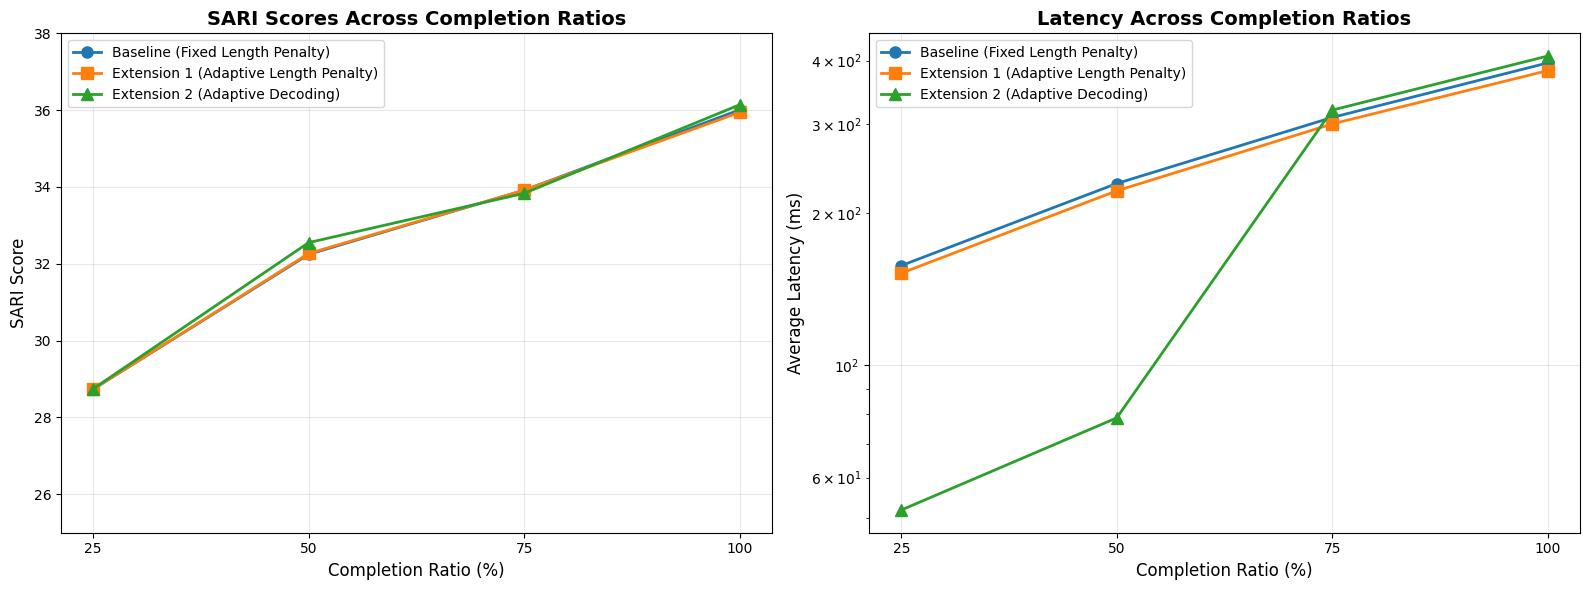

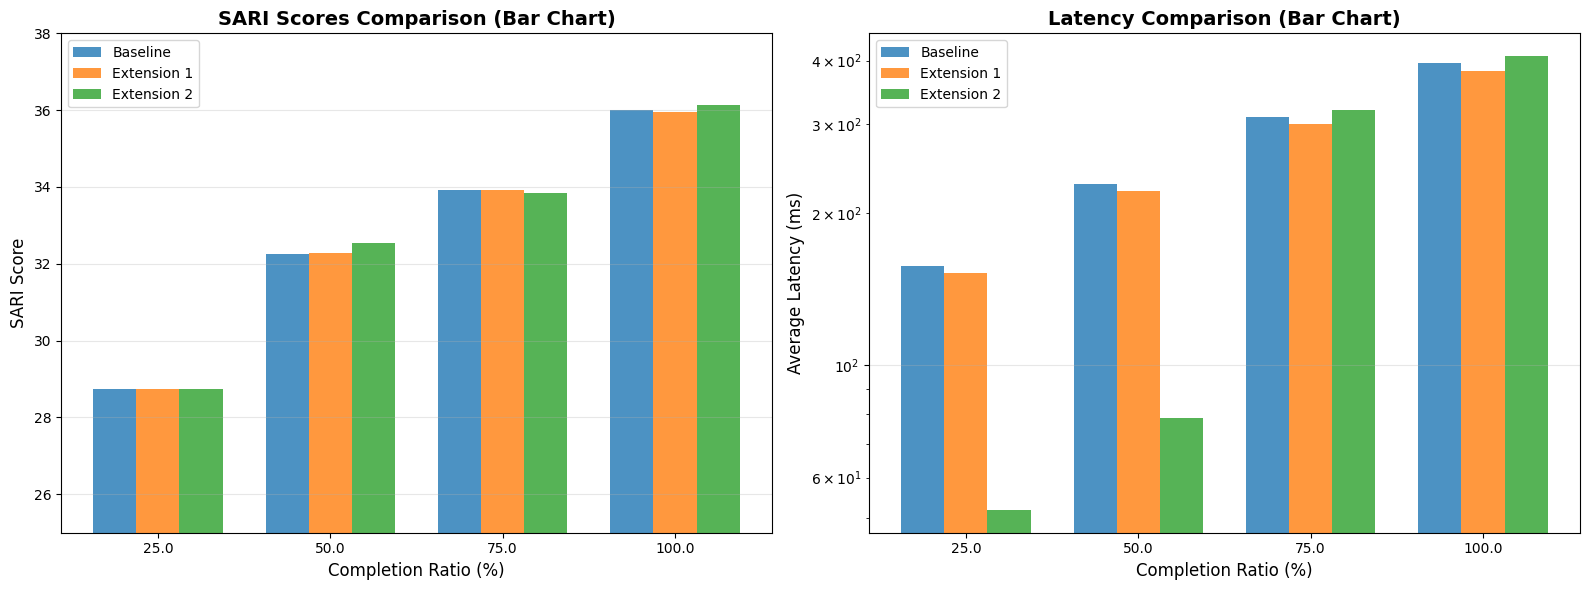

In [25]:
# Create plots for SARI scores
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: SARI Scores
ratios = [r*100 for r in completion_ratios]
baseline_saris = [np.mean(baseline_results[r]['sari']) for r in completion_ratios]
ext1_saris = [np.mean(extension1_results[r]['sari']) for r in completion_ratios]
ext2_saris = [np.mean(extension2_results[r]['sari']) for r in completion_ratios]

ax1.plot(ratios, baseline_saris, marker='o', label='Baseline (Fixed Length Penalty)', linewidth=2, markersize=8)
ax1.plot(ratios, ext1_saris, marker='s', label='Extension 1 (Adaptive Length Penalty)', linewidth=2, markersize=8)
ax1.plot(ratios, ext2_saris, marker='^', label='Extension 2 (Adaptive Decoding)', linewidth=2, markersize=8)
ax1.set_xlabel('Completion Ratio (%)', fontsize=12)
ax1.set_ylabel('SARI Score', fontsize=12)
ax1.set_title('SARI Scores Across Completion Ratios', fontsize=14, fontweight='bold')
ax1.set_xticks(ratios)
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=10)
ax1.set_ylim([25, 38])

# Plot 2: Latency
baseline_lats = [np.mean(baseline_results[r]['latency']) * 1000 for r in completion_ratios]
ext1_lats = [np.mean(extension1_results[r]['latency']) * 1000 for r in completion_ratios]
ext2_lats = [np.mean(extension2_results[r]['latency']) * 1000 for r in completion_ratios]

ax2.plot(ratios, baseline_lats, marker='o', label='Baseline (Fixed Length Penalty)', linewidth=2, markersize=8)
ax2.plot(ratios, ext1_lats, marker='s', label='Extension 1 (Adaptive Length Penalty)', linewidth=2, markersize=8)
ax2.plot(ratios, ext2_lats, marker='^', label='Extension 2 (Adaptive Decoding)', linewidth=2, markersize=8)
ax2.set_xlabel('Completion Ratio (%)', fontsize=12)
ax2.set_ylabel('Average Latency (ms)', fontsize=12)
ax2.set_title('Latency Across Completion Ratios', fontsize=14, fontweight='bold')
ax2.set_xticks(ratios)
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=10)
ax2.set_yscale('log')  # Log scale for better visualization

plt.tight_layout()
plt.show()

# Create bar chart comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart for SARI
x = np.arange(len(ratios))
width = 0.25

ax1.bar(x - width, baseline_saris, width, label='Baseline', alpha=0.8)
ax1.bar(x, ext1_saris, width, label='Extension 1', alpha=0.8)
ax1.bar(x + width, ext2_saris, width, label='Extension 2', alpha=0.8)
ax1.set_xlabel('Completion Ratio (%)', fontsize=12)
ax1.set_ylabel('SARI Score', fontsize=12)
ax1.set_title('SARI Scores Comparison (Bar Chart)', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(ratios)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3, axis='y')
ax1.set_ylim([25, 38])

# Bar chart for Latency
ax2.bar(x - width, baseline_lats, width, label='Baseline', alpha=0.8)
ax2.bar(x, ext1_lats, width, label='Extension 1', alpha=0.8)
ax2.bar(x + width, ext2_lats, width, label='Extension 2', alpha=0.8)
ax2.set_xlabel('Completion Ratio (%)', fontsize=12)
ax2.set_ylabel('Average Latency (ms)', fontsize=12)
ax2.set_title('Latency Comparison (Bar Chart)', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(ratios)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3, axis='y')
ax2.set_yscale('log')

plt.tight_layout()
plt.show()


In [26]:
# Detailed breakdown by component for all three approaches
print("\n" + "=" * 80)
print("Component-wise Analysis: Baseline vs Extension 1 vs Extension 2")
print("=" * 80)

components = ['keep', 'delete', 'add']
for comp in components:
    print(f"\n{comp.upper()} Component:")
    print(f"{'Completion Ratio':<20} {'Baseline':<15} {'Extension 1':<18} {'Extension 2':<18}")
    print("-" * 80)
    
    for ratio in completion_ratios:
        baseline_val = np.mean(baseline_results[ratio][comp])
        ext1_val = np.mean(extension1_results[ratio][comp])
        ext2_val = np.mean(extension2_results[ratio][comp])
        
        print(f"{ratio*100:>5.0f}%{'':<14} {baseline_val:>8.2f}      {ext1_val:>11.2f}      {ext2_val:>11.2f}")
    
    baseline_avg = np.mean([np.mean(baseline_results[r][comp]) for r in completion_ratios])
    ext1_avg = np.mean([np.mean(extension1_results[r][comp]) for r in completion_ratios])
    ext2_avg = np.mean([np.mean(extension2_results[r][comp]) for r in completion_ratios])
    
    print(f"{'Average':<20} {baseline_avg:>8.2f}      {ext1_avg:>11.2f}      {ext2_avg:>11.2f}")
    print(f"{'Ext1 vs Base':<20} {ext1_avg-baseline_avg:>+8.2f}      {'':<11}")
    print(f"{'Ext2 vs Base':<20} {ext2_avg-baseline_avg:>+8.2f}      {'':<11}")
    print(f"{'Ext2 vs Ext1':<20} {ext2_avg-ext1_avg:>+8.2f}      {'':<11}")

print("=" * 80)



Component-wise Analysis: Baseline vs Extension 1 vs Extension 2

KEEP Component:
Completion Ratio     Baseline        Extension 1        Extension 2       
--------------------------------------------------------------------------------
   25%                  22.90            22.90            22.76
   50%                  39.16            39.14            40.33
   75%                  47.98            47.98            48.17
  100%                  58.18            58.44            58.89
Average                 42.05            42.12            42.54
Ext1 vs Base            +0.06                 
Ext2 vs Base            +0.48                 
Ext2 vs Ext1            +0.42                 

DELETE Component:
Completion Ratio     Baseline        Extension 1        Extension 2       
--------------------------------------------------------------------------------
   25%                  61.76            61.76            61.82
   50%                  54.19            54.28            54.5